### Ground Truth Model Tuning

Processing imdb of 1000 samples, test_size=0.2
Number of positive samples: 489, negative samples: 511
TF-IDF + LR accuracy: 0.8100
TF-IDF + RF accuracy: 0.7600
SBERT + LR accuracy: 0.8900
SBERT + RF accuracy: 0.8500


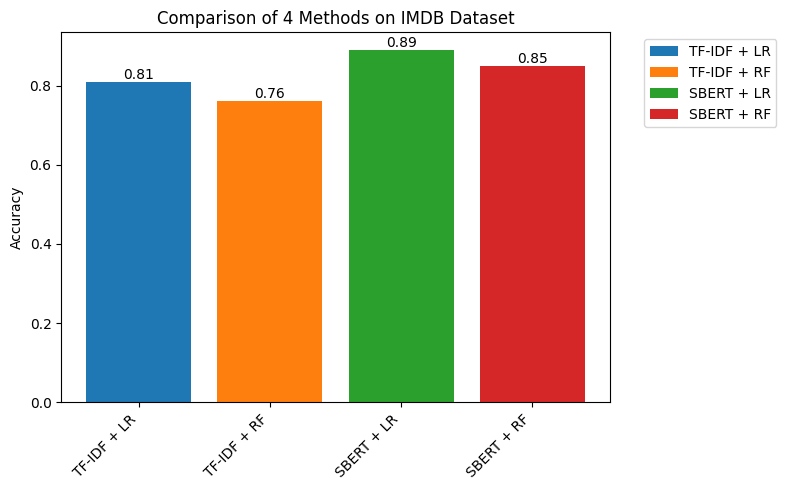

In [2]:
# %pip install datasets scikit-learn sentence-transformers openai pandas tqdm matplotlib

import os
import json
import random
import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import openai

from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

def load_selected_dataset(dataset_name: str, num_samples: int):
    """
    Loads a dataset from HuggingFace Datasets, returning texts, labels, and label_names.
    """
    if dataset_name == 'imdb':
        dataset = load_dataset('imdb', split='train+test').shuffle(seed=42)
        texts = dataset['text'][:num_samples]
        labels = dataset['label'][:num_samples]
        label_names = ['negative', 'positive']
    elif dataset_name == 'trec':
        dataset = load_dataset('trec', split='train').shuffle(seed=42)
        texts = dataset['text'][:num_samples]
        labels = dataset['coarse_label'][:num_samples]
        label_names = ['description', 'entity', 'abbreviation', 'human', 'location', 'numeric']
    else:
        raise ValueError("Unsupported dataset")
    return texts, labels, label_names

def train_model(texts, labels, embed_method, classifier, test_size=0.2):
    """
    Trains a given classifier (LogisticRegression or RandomForestClassifier)
    with a given embedding method (TfidfVectorizer or SentenceTransformer).
    Returns the trained model, fitted embedding (if Tfidf), and the accuracy score.
    """
    # Filter out samples with None labels
    filtered_texts = []
    filtered_labels = []
    for text, label in zip(texts, labels):
        if label is not None:
            filtered_texts.append(text)
            filtered_labels.append(label)
    
    if not filtered_labels:
        return None, None, 0.0
    
    # If labels are strings, convert them to numeric
    if isinstance(filtered_labels[0], str):
        unique_labels = np.unique(filtered_labels)
        label_map = {label: idx for idx, label in enumerate(unique_labels)}
        numeric_labels = [label_map[l] for l in filtered_labels]
    else:
        numeric_labels = filtered_labels

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        filtered_texts, numeric_labels,
        test_size=test_size, random_state=42
    )

    # 1) Tfidf embedding
    if isinstance(embed_method, TfidfVectorizer):
        X_train_vec = embed_method.fit_transform(X_train)
        X_test_vec = embed_method.transform(X_test)
    # 2) SentenceTransformer embedding
    elif isinstance(embed_method, SentenceTransformer):
        X_train_vec = embed_method.encode(X_train)
        X_test_vec = embed_method.encode(X_test)
    else:
        raise ValueError("Unsupported embedding method")

    # Train classifier
    classifier.fit(X_train_vec, y_train)
    y_pred = classifier.predict(X_test_vec)
    accuracy = accuracy_score(y_test, y_pred)

    return classifier, embed_method, accuracy

if __name__ == "__main__":
    # --- Experiment Parameters ---
    DATASET_NAME = 'imdb'  # or 'trec'
    NUM_SAMPLES = 1000
    TEST_SIZE = 0.2

    # 1) Load Data
    texts, real_labels, label_names = load_selected_dataset(DATASET_NAME, NUM_SAMPLES)

    print(f"Processing {DATASET_NAME} of {NUM_SAMPLES} samples, test_size={TEST_SIZE}")
    # Example for binary classification (IMDB):
    print(f"Number of positive samples: {real_labels.count(1)}, negative samples: {real_labels.count(0)}")

    # 2) Define our four combinations of embeddings and classifiers
    combinations = [
        ("TF-IDF + LR", TfidfVectorizer(max_features=1000), LogisticRegression()),
        ("TF-IDF + RF", TfidfVectorizer(max_features=1000), RandomForestClassifier()),
        ("SBERT + LR", SentenceTransformer('all-mpnet-base-v2'), LogisticRegression()),
        ("SBERT + RF", SentenceTransformer('all-mpnet-base-v2'), RandomForestClassifier()),
    ]

    # 3) Train all four models and store accuracy
    method_names = []
    accuracies = []
    for combo_name, embed_method, model in combinations:
        _, _, acc = train_model(texts, real_labels, embed_method, model, test_size=TEST_SIZE)
        method_names.append(combo_name)
        accuracies.append(acc)
        print(f"{combo_name} accuracy: {acc:.4f}")

    # 4) Plot a bar chart comparing accuracies
    plt.figure(figsize=(8, 5))

    x_positions = np.arange(len(method_names))
    # Different colors for each bar (extend or change if you have more bars)
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

    # Plot each bar with a distinct color
    bars = plt.bar(x_positions, accuracies, color=colors)

    # Display accuracy on top of each bar
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0,
                 height,
                 f"{height:.2f}",
                 ha='center', va='bottom')

    # Assign each bar a label for the legend
    for bar, label in zip(bars, method_names):
        bar.set_label(label)

    plt.xticks(x_positions, method_names, rotation=45, ha='right')
    plt.ylabel("Accuracy")
    plt.title(f"Comparison of 4 Methods on {DATASET_NAME.upper()} Dataset")

    # Place the legend so it doesn't overlap with the bars
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

    plt.tight_layout()  # Adjust layout so everything fits nicely
    plt.show()


### LLM-Based Labeling: LLM-Direct, LLM-LF and LLM-LF-MV

In [5]:
# %pip install datasets scikit-learn sentence-transformers openai pandas tqdm

import os
import json
import random
import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from tqdm import tqdm
import openai
from collections import Counter

openai.api_key = "provide your api key here"

def ensure_directories(dataset_name: str):
    """
    Create the folder structure:
      <dataset_name>_dataset/labeling_functions/keyword_search/
    Also create <dataset_name>_dataset/ if not present.
    """
    base_dir = os.path.join(dataset_name, "labeling_functions", "keyword_search")
    os.makedirs(base_dir, exist_ok=True)

def load_selected_dataset(dataset_name: str, num_samples: int):
    if dataset_name == 'imdb':
        dataset = load_dataset('imdb', split='train+test').shuffle(seed=42)
        texts = dataset['text'][:num_samples]
        labels = dataset['label'][:num_samples]
        label_names = ['negative', 'positive']
    elif dataset_name == 'trec':
        dataset = load_dataset('trec', split='train').shuffle(seed=42)
        texts = dataset['text'][:num_samples]
        labels = dataset['coarse_label'][:num_samples]
        label_names = ['description', 'entity', 'abbreviation', 'human', 'location', 'numeric']
    else:
        raise ValueError("Unsupported dataset")
    return texts, labels, label_names

def train_ground_truth_model(texts, labels, test_size=0.2):
    # Filter out samples with None labels
    filtered_texts = []
    filtered_labels = []
    for text, label in zip(texts, labels):
        if label is not None:
            filtered_texts.append(text)
            filtered_labels.append(label)
    
    if not filtered_labels:  # Handle empty labels case
        return None, None, 0.0
    
    # Check label type and convert if needed
    if isinstance(filtered_labels[0], str):
        unique_labels = np.unique(filtered_labels)
        label_map = {label: idx for idx, label in enumerate(unique_labels)}
        numeric_labels = [label_map[l] for l in filtered_labels]
    else:
        numeric_labels = filtered_labels  # Use numerical labels directly

    # Split and train
    X_train, X_test, y_train, y_test = train_test_split(
        filtered_texts, numeric_labels,
        test_size=test_size, random_state=42
    )
    
    # vectorizer = TfidfVectorizer(max_features=1000)
    # X_train_vec = vectorizer.fit_transform(X_train)
    # X_test_vec = vectorizer.transform(X_test)

    encoder = SentenceTransformer('all-mpnet-base-v2')
    X_train_vec = encoder.encode(X_train)
    X_test_vec = encoder.encode(X_test)
    
    model = LogisticRegression()
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    
    return model, encoder, accuracy_score(y_test, y_pred)

def train_with_llm_labels_on_train_but_real_labels_on_test(
    texts, llm_labels, real_labels, test_size=0.2
):
    """
    Splits once based on real_labels, then trains on LLM labels in the train split,
    evaluates on real labels in the test split.
    """
    # Indices
    indices = list(range(len(texts)))
    train_idx, test_idx = train_test_split(indices, test_size=test_size, random_state=42, stratify=real_labels)

    X_train = [texts[i] for i in train_idx]
    y_train = [llm_labels[i] for i in train_idx]  # LLM-based
    X_test = [texts[i] for i in test_idx]
    y_test = [real_labels[i] for i in test_idx]   # Real labels

    # After y_train, y_test are created:
    print("Train distribution (LLM labels):", Counter(y_train))
    print("Test distribution (Real labels) :", Counter(y_test))

    # Filter out any training examples where LLM gave None (unlabeled)
    filtered_train_texts = []
    filtered_train_labels = []
    for tx, lb in zip(X_train, y_train):
        if lb is not None:
            filtered_train_texts.append(tx)
            filtered_train_labels.append(lb)

    if not filtered_train_labels:
        # If everything is None, return trivial accuracy
        return None, None, 0.0

    # Convert string labels to numeric if needed
    if isinstance(filtered_train_labels[0], str):
        unique_labels = sorted(list(set(filtered_train_labels)))
        label_map = {label: idx for idx, label in enumerate(unique_labels)}
        numeric_train_labels = [label_map[lbl] for lbl in filtered_train_labels]
    else:
        numeric_train_labels = filtered_train_labels

    # Convert test labels to the same numeric form if needed
    if isinstance(y_test[0], str):
        # Collect possible labels from train set + test set
        all_unique_labels = sorted(list(set(filtered_train_labels + y_test)))
        label_map_test = {label: idx for idx, label in enumerate(all_unique_labels)}

        numeric_test_labels = [label_map_test[lbl] for lbl in y_test]
    else:
        numeric_test_labels = y_test

    # vectorizer = TfidfVectorizer(max_features=1000)
    # X_train_vec = vectorizer.fit_transform(filtered_train_texts)
    # X_test_vec = vectorizer.transform(X_test)

    encoder = SentenceTransformer('all-mpnet-base-v2')
    X_train_vec = encoder.encode(filtered_train_texts)
    X_test_vec = encoder.encode(X_test)

    model = LogisticRegression()
    model.fit(X_train_vec, numeric_train_labels)
    y_pred = model.predict(X_test_vec)
    acc = accuracy_score(numeric_test_labels, y_pred)

    return model, encoder, acc

def call_gpt(prompt: str, model="gpt-4o"):
    """
    Helper function to call GPT-4 (or GPT-3.5, etc.).
    Modify the `model` parameter as needed.
    """
    response = openai.ChatCompletion.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.2,
        response_format={"type": "json_object"}
    )
    return response.choices[0].message['content'], response.usage['prompt_tokens'], response.usage['completion_tokens']


def get_or_create_llm_labels(texts: list, label_names: list, dataset_name: str):
    """
    Returns a list of LLM-generated labels for all texts.
    Cache is stored in <dataset_name>/llm_labels.json.
    """

    # Cache file
    cache_file = os.path.join(dataset_name, 'llm_labels.json')

    try:
        with open(cache_file, 'r') as f:
            label_cache = json.load(f)
    except FileNotFoundError:
        label_cache = {}

    total_prompt_tokens = 0
    total_completion_tokens = 0

    if dataset_name == 'imdb_dataset':
        task_desc = "Classify the sentiment of movie reviews as positive or negative."
        example1 = "This movie was fantastic and really captivating! -> positive"
        example2 = "The plot was boring and the acting was terrible. -> negative"
    elif dataset_name == 'trec_dataset':
        task_desc = ("Classify the type of question into one of: "
                     "description, entity, abbreviation, human, location, numeric.")
        example1 = "What is the capital of France? -> location"
        example2 = "Who invented the telephone? -> human"
    else:
        task_desc = "Classify the text."
        example1 = ""
        example2 = ""

    batch_size = 10
    for i in tqdm(range(0, len(texts), batch_size), desc="LLM labeling"):
        batch_texts = texts[i:i+batch_size]

        # Skip if all texts in this batch are already in the cache
        if all(text in label_cache for text in batch_texts):
            continue

        prompt = (
            f"{task_desc}\n"
            f"Examples:\n{example1}\n{example2}\n\n"
            "Now, let's think step by step and please label the following texts. Respond with a JSON object mapping each numbered text to its label. "
            "For example:\n"
            '{ "1": "positive", "2": "negative" }\n\n'
            "Texts to label:\n"
        )
        for idx, text in enumerate(batch_texts):
            prompt += f"{idx+1}. {text}\n"

        response, pt, ct = call_gpt(prompt)
        total_prompt_tokens += pt
        total_completion_tokens += ct

        try:
            # Parse the JSON response from the LLM
            labels_dict = json.loads(response)
        except Exception as e:
            print(f"Error parsing JSON response for batch starting at index {i}: {e}")
            labels_dict = {}

        # Map the responses back to the corresponding texts
        for idx, text in enumerate(batch_texts):
            # The keys in the JSON are expected to be string numbers like "1", "2", etc.
            label = labels_dict.get(str(idx+1), None)
            # Validate the label is known
            label_cache[text] = label if label in label_names else None

        # Save periodically
        if i % 100 == 0:
            with open(cache_file, 'w') as f:
                json.dump(label_cache, f)

    # Final save of cache
    with open(cache_file, 'w') as f:
        json.dump(label_cache, f)

    # Build the final list of labels in the original order of texts
    llm_labels = [label_cache.get(text, None) for text in texts]
    return llm_labels, total_prompt_tokens, total_completion_tokens

def sample_random(texts, sample_percent=0.05):
    num_samples = int(len(texts) * sample_percent)
    indices = random.sample(range(len(texts)), num_samples)
    return indices, [texts[i] for i in indices]


def sample_cluster(texts, sample_percent=0.05, n_clusters=10):
    model = SentenceTransformer('all-mpnet-base-v2')
    embeddings = model.encode(texts)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(embeddings)

    cluster_indices = {}
    for idx, cluster in enumerate(clusters):
        cluster_indices.setdefault(cluster, []).append(idx)

    total_samples = int(len(texts) * sample_percent)
    sampled_indices = []
    for cluster, idxs in cluster_indices.items():
        cluster_samples = int(total_samples * len(idxs) / len(texts))
        sampled_indices.extend(random.sample(idxs, min(cluster_samples, len(idxs))))

    # Remove duplicates if cluster sampling doesn't partition cleanly
    sampled_indices = list(set(sampled_indices))
    return sampled_indices, [texts[i] for i in sampled_indices]


def load_labeling_rules_if_any(dataset_name: str):
    """
    Attempts to load keyword-based labeling rules from
      <dataset_name>/labeling_functions/keyword_search/keywords.txt
    Returns a dict if found, else {}.
    """
    rule_file = os.path.join(dataset_name, 'labeling_functions', 'keyword_search', 'keywords.txt')

    if os.path.isfile(rule_file):
        try:
            with open(rule_file, 'r') as f:
                rules = json.load(f)  # It's a JSON file, though named 'keywords.txt'
            return rules
        except:
            return {}
    return {}

def save_labeling_rules(dataset_name: str, rules: dict):
    """
    Saves labeling rules to <dataset_name>/labeling_functions/keyword_search/keywords.txt as JSON.
    """
    rule_file = os.path.join(dataset_name, 'labeling_functions', 'keyword_search', 'keywords.txt')
    with open(rule_file, 'w') as f:
        json.dump(rules, f, indent=2)

def generate_labeling_rules_aggregated(samples, labels, label_names, dataset_name, chunk_size=10):
    aggregated_rules = {}
    total_pt = 0  # total prompt tokens
    total_ct = 0  # total completion tokens
    
    # Process the samples in chunks of chunk_size (default=10)
    for i in range(0, len(samples), chunk_size):
        chunk_samples = samples[i:i+chunk_size]
        chunk_labels = labels[i:i+chunk_size]
        
        # Prepare the examples for this chunk
        examples = '\n'.join([f"{text} -> {label}" 
                              for text, label in zip(chunk_samples, chunk_labels) 
                              if label is not None])
        
        # Create the prompt for the current chunk
        prompt = f"""Create text classification rules (as keyword lists) for the dataset {dataset_name}. 
Here are some labeled examples:
{examples}

Generate a JSON object mapping labels to a list of keywords, for example:
{{
  "positive": ["awesome", "good", "amazing"],
  "negative": ["bad", "terrible"]
}}
Only provide JSON as output. Do not add commentary. Now let's think step by step and give me the answer.
"""
        # Call the LLM (assuming call_gpt returns response, prompt tokens, completion tokens)
        response, pt, ct = call_gpt(prompt)
        total_pt += pt
        total_ct += ct
        
        try:
            # Parse and filter the returned JSON rules
            rules = json.loads(response)
            valid_rules = {lbl: kwds for lbl, kwds in rules.items() if lbl in label_names}
            
            # Aggregate the keywords across chunks
            for lbl, keywords in valid_rules.items():
                if lbl in aggregated_rules:
                    aggregated_rules[lbl].extend(keywords)
                else:
                    aggregated_rules[lbl] = keywords
        except Exception as e:
            print(f"Error parsing response for chunk starting at index {i}: {e}")
    
    # Optional: Deduplicate keywords for each label
    for lbl in aggregated_rules:
        aggregated_rules[lbl] = list(set(aggregated_rules[lbl]))
    
    return aggregated_rules, total_pt, total_ct

def apply_labeling_rules(texts, rules):
    labels = []
    for text in texts:
        text_lower = text.lower()
        assigned_label = None
        for lbl, keywords in rules.items():
            if any(kw.lower() in text_lower for kw in keywords):
                assigned_label = lbl
                break
        labels.append(assigned_label)
    return labels

def apply_labeling_rules_majority_vote(texts, rules):
    """
    Applies each keyword as if it's a separate labeling function.
    For each text:
      - Collect all labels contributed by any keyword that appears in the text.
      - If there's a unique majority label, assign it.
      - Otherwise (tie or no matches), return None.
    
    :param texts: list of strings
    :param rules: dict mapping label -> list of keywords
    :return: list of labels (or None) for each text
    """
    final_labels = []
    for text in texts:
        text_lower = text.lower()
        candidate_labels = []

        # Each (label, keyword) acts like its own labeling function.
        # If the keyword is found, that labeling function "votes" for that label.
        for lbl, keywords in rules.items():
            for kw in keywords:
                if kw.lower() in text_lower:
                    candidate_labels.append(lbl)
        
        if candidate_labels:
            # Tally up votes
            label_counts = Counter(candidate_labels)
            # The most_common returns a list of (label, count) pairs
            most_common_label, top_count = label_counts.most_common(1)[0]

            # Check if there's a tie
            all_top_labels = [l for l, c in label_counts.items() if c == top_count]
            if len(all_top_labels) == 1:
                # Unique majority
                final_labels.append(most_common_label)
            else:
                # Tie -> abstain (or fallback to LLM)
                final_labels.append(None)
        else:
            # No matched keywords -> abstain (or fallback to LLM)
            final_labels.append(None)

    return final_labels

def calculate_cost(prompt_tokens, completion_tokens):
    """
    Example cost calculation with GPT-4 pricing.
    Adjust as appropriate.
    """
    return (prompt_tokens * 0.0025 / 1000) + (completion_tokens * 0.01 / 1000)

if __name__ == "__main__":
    # Experiment Parameters
    DATASET_NAME = 'imdb'  # or 'trec'
    NUM_SAMPLES = 1000
    TEST_SIZE = 0.2

    # 1) Load Data
    texts, real_labels, label_names = load_selected_dataset(DATASET_NAME, NUM_SAMPLES)
    num_positive = real_labels.count(1)
    num_negative = real_labels.count(0)

    DATASET_NAME = DATASET_NAME + "_dataset"
    ensure_directories(DATASET_NAME)

    # Ground Truth Baseline
    gt_model, _, gt_acc = train_ground_truth_model(texts, real_labels, TEST_SIZE)

    # 2) LLM Direct Labeling
    llm_labels, llm_pt, llm_ct = get_or_create_llm_labels(texts, label_names, DATASET_NAME)
 
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

    # Map llm_labels to predictions: "positive" → 1, "negative" → 0, "null" → None (i.e., abstain)
    mapped_preds = [1 if lbl == "positive" else 0 if lbl == "negative" else None for lbl in llm_labels]

    # Filter out the "null" predictions
    filtered_real = [real for real, pred in zip(real_labels, mapped_preds) if pred is not None]
    filtered_preds = [pred for pred in mapped_preds if pred is not None]

    # Metrics on all data (treat "null" as negative for rough overall accuracy)
    llm_direct_acc = accuracy_score(real_labels, [1 if lbl == "positive" else 0 for lbl in llm_labels])
    print(f"LLM direct labeling accuracy (on all data, null → negative): {llm_direct_acc:.4f}")

    # Metrics only on non-null predictions
    if filtered_preds:
        print("Evaluation on non-null predictions:")
        print(f"  Accuracy       : {accuracy_score(filtered_real, filtered_preds):.4f}")
        print(f"  Precision      : {precision_score(filtered_real, filtered_preds):.4f}")
        print(f"  Recall         : {recall_score(filtered_real, filtered_preds):.4f}")
        print(f"  F1 Score       : {f1_score(filtered_real, filtered_preds):.4f}")
        print("  Confusion Matrix:")
        print(confusion_matrix(filtered_real, filtered_preds))
        print("\nClassification Report:")
        print(classification_report(filtered_real, filtered_preds, digits=4))
    else:
        print("No non-null predictions to evaluate.")

    #   Train a model using LLM labels as training data, evaluate on real labels
    llm_model, _, llm_model_acc = train_with_llm_labels_on_train_but_real_labels_on_test(
        texts, llm_labels, real_labels, test_size=TEST_SIZE
    )

    # 3) Our Method - (e.g.) Random Sampling for generating rules
    #   3.1) Sample data
    sampled_indices, sampled_texts = sample_random(texts)
    #   The LLM labels are cached in the file; reuse them
    sampled_labels = [llm_labels[idx] for idx in sampled_indices]

    #   3.2) Try to load existing labeling rules from disk
    rules = load_labeling_rules_if_any(DATASET_NAME)

    #   If none found, generate them from the LLM
    rule_pt = rule_ct = 0
    if not rules:
        rules, rule_pt, rule_ct = generate_labeling_rules_aggregated(sampled_texts, sampled_labels, label_names, DATASET_NAME)
        save_labeling_rules(DATASET_NAME, rules)

    #   3.3) Apply labeling rules
    rule_labels = apply_labeling_rules_majority_vote(texts, rules)
    rule_acc = accuracy_score(real_labels, [1 if lbl == "positive" else 0 for lbl in rule_labels])
    print(f"LLM-generated Labeling Function accuracy (on all data, null → negative): {rule_acc:.4f}")

    #   3.4) For data points not labeled by rules, fall back on LLM
    remaining_indices = [i for i, lb in enumerate(rule_labels) if lb is None]
    remaining_texts = [texts[i] for i in remaining_indices]

    #   - We can re-use the same function that retrieves LLM labels (it won’t re-label if in cache).
    remaining_llm_labels, rem_pt, rem_ct = get_or_create_llm_labels(remaining_texts, label_names, DATASET_NAME)

    final_labels = rule_labels[:]
    for idx, lbl in zip(remaining_indices, remaining_llm_labels):
        final_labels[idx] = lbl

    for idx, lbl in zip(sampled_indices, sampled_labels):
        final_labels[idx] = lbl

    #   3.5) Train a model with final_labels (on the train split), test on real labels
    _, _, our_acc = train_with_llm_labels_on_train_but_real_labels_on_test(
        texts, final_labels, real_labels, test_size=TEST_SIZE
    )

    # 4) Stats & Cost
    llm_direct_cost = calculate_cost(llm_pt, llm_ct)
    llm_mix_cost = calculate_cost(rule_pt + rem_pt, rule_ct + rem_ct)

    #   (A) Labeling function stats
    num_labeling_functions = len(rules)
    print(f"Keywords generated by LLM")
    for key, value in rules.items():
        print(f"Label: {key}, Keywords: {value}")

    #   (B) How many got labeled by rules vs. LLM?
    num_rule_labeled = sum(1 for lb in rule_labels if lb is not None)
    # final_labels might have some None if the LLM also returned None
    num_llm_labeled = sum(1 for lb in final_labels if lb is not None) - num_rule_labeled
    print(f"Number of data points labeled by rules: {num_rule_labeled}")
    print(f"Number of data points labeled by LLM (in fallback): {num_llm_labeled}")

    print(f"Ground Truth Accuracy: {gt_acc:.4f}")
    print(f"LLM Direct Accuracy: {llm_model_acc:.4f}, Direct Cost: ${llm_direct_cost:.2f}")
    print(f"Our Method Accuracy: {our_acc:.4f}, Total Mix Cost: ${llm_mix_cost:.2f}")

    with open(f"{DATASET_NAME}/summary_{NUM_SAMPLES}_randomSampling.txt", 'w') as f:
        f.write(f"Processing {DATASET_NAME} of {NUM_SAMPLES} samples, test percentage is {TEST_SIZE}" + "\n")
        f.write(f"Number of positive samples: {num_positive}, negative samples: {num_negative}" + "\n")
        f.write(f"LLM direct labeling accuracy (on all data, null → negative): {llm_direct_acc:.4f}" + "\n")
        f.write(f"LLM-generated Labeling Function accuracy (on all data, null → negative): {rule_acc:.4f}" + "\n")
        f.write(f"LLM direct labeling report:\n{classification_report(filtered_real, filtered_preds, digits=4)}" + "\n")
        f.write(f"Model Trained on Ground Truth, Accuracy: {gt_acc:.4f}" + "\n")
        f.write(f"Model Trained on LLM Direct, Accuracy: {llm_model_acc:.4f}, Token: {llm_pt}, {llm_ct}, Cost: ${llm_direct_cost:.2f}" + "\n")
        f.write(f"Model Trained on LLM Direct and Labeling Functions, Accuracy: {our_acc:.4f}, Token: {rule_pt}, {rule_ct}, {rem_pt}, {rem_ct}, Cost: ${llm_mix_cost:.2f}" + "\n")
        f.write(f"Number of data points labeled by rules: {num_rule_labeled}" + "\n")
        f.write(f"Number of data points labeled by LLM (in fallback): {num_llm_labeled}" + "\n")

LLM labeling: 100%|██████████| 100/100 [00:00<00:00, 44020.82it/s]


LLM direct labeling accuracy (on all data, null → negative): 0.9510
Evaluation on non-null predictions:
  Accuracy       : 0.9567
  Precision      : 0.9803
  Recall         : 0.9296
  F1 Score       : 0.9543
  Confusion Matrix:
[[502   9]
 [ 34 449]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9366    0.9824    0.9589       511
           1     0.9803    0.9296    0.9543       483

    accuracy                         0.9567       994
   macro avg     0.9585    0.9560    0.9566       994
weighted avg     0.9578    0.9567    0.9567       994

Train distribution (LLM labels): Counter({'negative': 430, 'positive': 364, None: 6})
Test distribution (Real labels) : Counter({0: 102, 1: 98})
LLM-generated Labeling Function accuracy (on all data, null → negative): 0.7430


LLM labeling: 100%|██████████| 13/13 [00:00<00:00, 64757.66it/s]

Train distribution (LLM labels): Counter({'positive': 496, 'negative': 304})
Test distribution (Real labels) : Counter({0: 102, 1: 98})


Keywords generated by LLM
Label: positive, Keywords: ['triumphant', 'sexy', 'outstanding', 'satisfying', 'recommend', 'hilarious', 'world-class', 'elegant', 'funny', 'suspenseful', 'fan', 'enjoyable', 'well played', 'good', 'wonderful', 'opportunity', 'touching', 'awesome', 'fun', 'laughing', 'chemistry', 'effective', 'superb', 'classic', 'delight', 'stunning', 'legend', 'tribute', 'convincing', 'beautifully', 'masterpiece', 'love', 'joy', 'endearing', 'excellent', 'twist', 'story', 'heart-warming', 'beautiful', 'fantastic', 'touched', 'groovy', 'unique', 'delightfully', 'best', 'amazing', 'incredible', 'liked', 'greatest', 'entertaining', 'appreciate', 'favorite', 'enjoy', 'welcome', 'interesting', 'comfortable', 'perfect', 'enthralled', 'watchable', 'phenomenal', 'engaging', 'great', 'captivating']
Label: negative, Keywords: ['obligatory', 'repulsive', 'disgusting', 'not impressed', 'predictable', 'downer', 'dopey', 'mistakes', 'humiliating', 'god-awful', 'simplistic', 'no expectatio

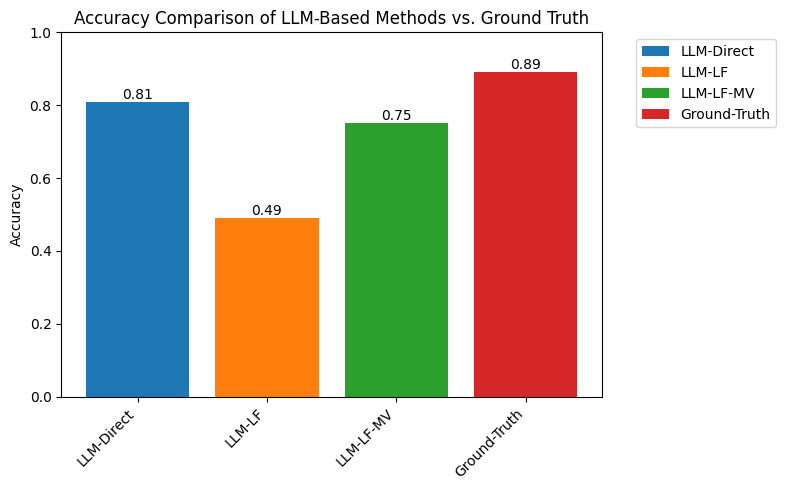

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Method names and corresponding accuracies
methods = ["LLM-Direct", "LLM-LF", "LLM-LF-MV", "Ground-Truth"]
accuracies = [0.81, 0.49, 0.75, 0.89]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

# Plot setup
plt.figure(figsize=(8, 5))
x = np.arange(len(methods))
bars = plt.bar(x, accuracies, color=colors)

# Add accuracy labels on top of each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2,
             height,
             f"{height:.2f}",
             ha='center', va='bottom')

# Add individual labels for legend
for bar, label in zip(bars, methods):
    bar.set_label(label)

plt.xticks(x, methods, rotation=45, ha='right')
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison of LLM-Based Methods vs. Ground Truth")
plt.ylim(0, 1.0)

# Place legend outside plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

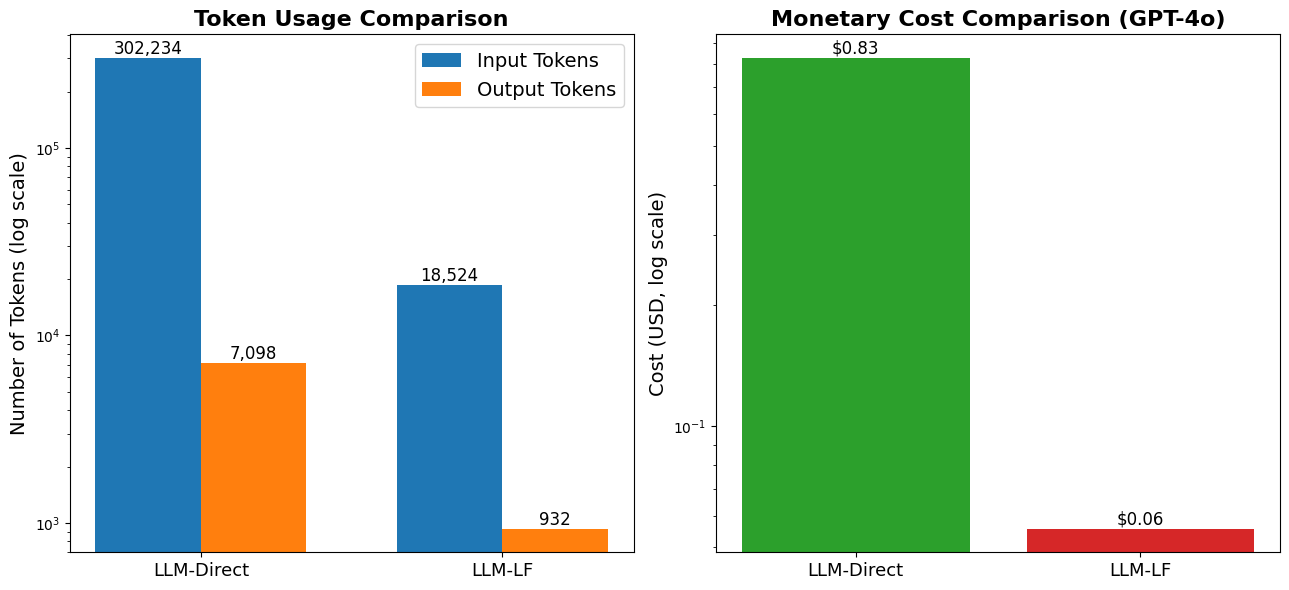

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Token and cost data
methods = ["LLM-Direct", "LLM-LF"]
input_tokens = [302234, 18524]
output_tokens = [7098, 932]

# GPT-4o pricing
input_price_per_million = 2.5
output_price_per_million = 10.0

# Calculate monetary cost
input_cost = [t / 1e6 * input_price_per_million for t in input_tokens]
output_cost = [t / 1e6 * output_price_per_million for t in output_tokens]
total_cost = [i + o for i, o in zip(input_cost, output_cost)]

# Plot setup
fig, axs = plt.subplots(1, 2, figsize=(13, 6))

# Common font settings
label_fontsize = 14
title_fontsize = 16
tick_fontsize = 13
annot_fontsize = 12

# Left: Input and Output tokens (log scale)
x = np.arange(len(methods))
width = 0.35

axs[0].bar(x - width/2, input_tokens, width, label="Input Tokens", color="tab:blue")
axs[0].bar(x + width/2, output_tokens, width, label="Output Tokens", color="tab:orange")
axs[0].set_xticks(x)
axs[0].set_xticklabels(methods, fontsize=tick_fontsize)
axs[0].set_ylabel("Number of Tokens (log scale)", fontsize=label_fontsize)
axs[0].set_title("Token Usage Comparison", fontsize=title_fontsize, fontweight='bold')
axs[0].set_yscale("log")
axs[0].legend(fontsize=label_fontsize)

# Annotate token values
for i in range(len(methods)):
    axs[0].text(x[i] - width/2, input_tokens[i], f"{input_tokens[i]:,}",
                ha='center', va='bottom', fontsize=annot_fontsize)
    axs[0].text(x[i] + width/2, output_tokens[i], f"{output_tokens[i]:,}",
                ha='center', va='bottom', fontsize=annot_fontsize)

# Right: Monetary Cost (log scale)
bars = axs[1].bar(x, total_cost, color=["tab:green", "tab:red"])
axs[1].set_xticks(x)
axs[1].set_xticklabels(methods, fontsize=tick_fontsize)
axs[1].set_ylabel("Cost (USD, log scale)", fontsize=label_fontsize)
axs[1].set_title("Monetary Cost Comparison (GPT-4o)", fontsize=title_fontsize, fontweight='bold')
axs[1].set_yscale("log")

# Annotate cost
for bar in bars:
    yval = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width()/2, yval, f"${yval:.2f}",
                ha='center', va='bottom', fontsize=annot_fontsize)

plt.tight_layout()
plt.show()
